
# Dike Model Continued - Subspace Partitioning

In the previous assignment, we focused on getting acquainted with the dike model. In this assignment, we will continue with the dike model, focusing explicitly on using it for open exploration and scenario discovery using PRIM.

**It is paramount that you are using the dike problem with the appropriate decision variables and parameters.**


In [39]:
from ema_workbench import Model, RealParameter, ScalarOutcome, IntegerParameter, CategoricalParameter, perform_experiments, load_results
from ema_workbench.analysis import prim
from dike_model_function import DikeNetwork
from ema_workbench.util import ema_logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define the sum_over function
def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

# Configure logging
ema_logging.log_to_stderr(ema_logging.INFO)

# Define the function to get the model for the given problem formulation
def get_model_for_problem_formulation():
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)
    
    #specify uncertainties
    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))
    
    dike_model.uncertainties = uncertainties

    # Set levers (example, adapt as necessary)
    levers = [IntegerParameter(f"raise {i}", 0, 10) for i in range(1, 6)]
    dike_model.levers = levers

    #specify outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
            [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
            ["RfR Total Costs", "Expected Evacuation Costs"] 
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        )
    ]
    dike_model.outcomes = outcomes

    return dike_model

# Get the model for the problem formulation
dike_model = get_model_for_problem_formulation()


In [37]:
experiments = pd.read_csv('experiments_bestpolicy.csv')
outcomes = pd.read_csv('outcomes_bestpolicy.csv')

In [36]:
outcomes_of_interest = ['Expected Annual Damage', 'Dike Investment Costs',]
ooi = outcomes_of_interest[0]

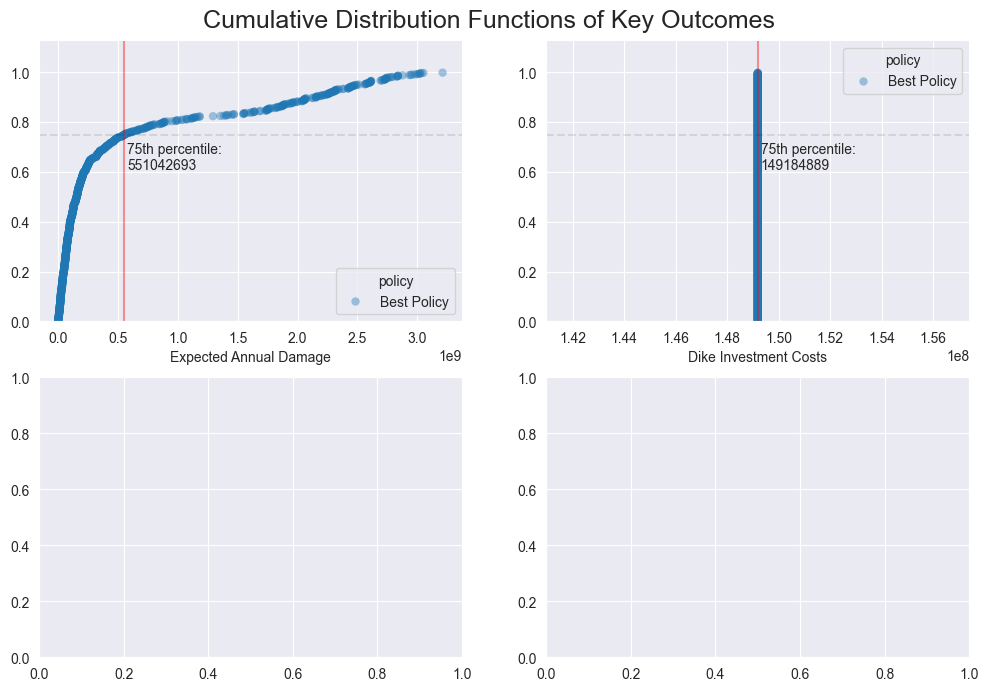

In [41]:
N = experiments.shape[0]
performance_threshold = None

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(outcomes_of_interest, axs.ravel()):
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N)/N
    df = df.reset_index()
    
    # Plot
    sns.scatterplot(data=df, x=col, y='y', hue='policy',
                    legend=True, linewidth=0,
                    alpha=0.4, palette='tab10', ax=ax)

    # Plot line at 75th percentile
    q3 = int(N*0.75)
    ax.axhline(q3/N, color='k', alpha=0.1, ls='--')
    ax.axvline(df[col][q3], label=str(df[col][q3]),
               color='r', alpha=0.4)
    
    # Label line with 75th percentile value
    annotation_point = int(N*0.61)/N # tested to line up with a gridline
    if col.split('_')[-1] == 'EAD':
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.5f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.0f}", 
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    
    # Save performance threshold (75th percentile of outcome of interest)
    if (col == ooi):
        performance_threshold = df[col][q3]

    # Set up graph
    sns.despine(ax=ax)
    col_name = ' '.join(col.split('_'))
    ax.set(xlabel=col_name, ylabel=None, ylim=[0, 1.125])

plt.suptitle(f'Cumulative Distribution Functions of Key Outcomes',
             fontsize=18, y=0.92)
plt.savefig('vulnerability_bestpolicy')
plt.show()

PRIM for expected annual damage

In [61]:
data = pd.read_csv('experiments_and_outcomes.csv')

# Define the outcome of interest (change 'Total Costs' to the actual column name you are interested in)
outcome_variable = 'Expected Annual Damage'


# Define performance threshold (you may need to adjust this based on your specific needs)
performance_threshold = data[outcome_variable].mean()

# List of uncertainties
uncertainties = [u.name for u in dike_model.uncertainties]

# PRIM Analysis
prim_alg = prim.Prim(data, data[outcome_variable] > performance_threshold, threshold=0.75)
box1 = prim_alg.find_box()
# 
# # Display the PRIM results
# box1.show_details()
# # box1.show_tradeoff()
# 
# # Save the PRIM results for further analysis
# prim_results = box1.inspect(5)  # Example to inspect the top 5 boxes
# prim_results.to_csv('prim_results.csv')

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1000 points remaining, containing 237 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.231, coverage: 0.9746835443037974, density: 1.0 restricted_dimensions: 1


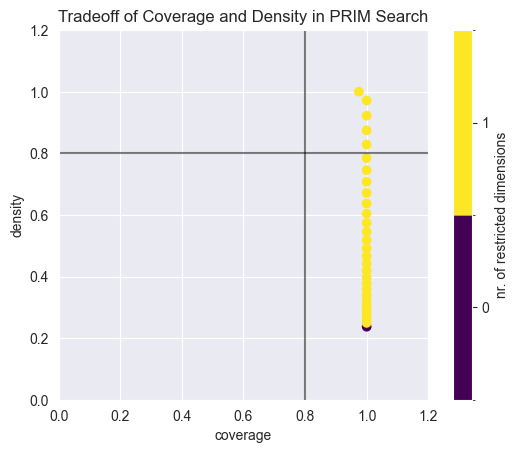

In [57]:
box1.show_tradeoff()

plt.hlines(y=[0.80], xmin=0, xmax=1.2, colors='k', alpha=0.5)
plt.vlines(x=[0.80], ymin=0, ymax=1.2, colors='k', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search')
plt.savefig('vulnerability__prim_trajectory.png')
plt.show()

coverage      1.000000
density       0.671388
id           20.000000
k           237.000000
mass          0.353000
mean          0.671388
n           353.000000
res_dim       1.000000
Name: 20, dtype: float64

                              box 20                                     
                                 min           max      qp value qp value
Expected Annual Damage  2.557453e+08  5.116508e+09  9.685916e-67      NaN


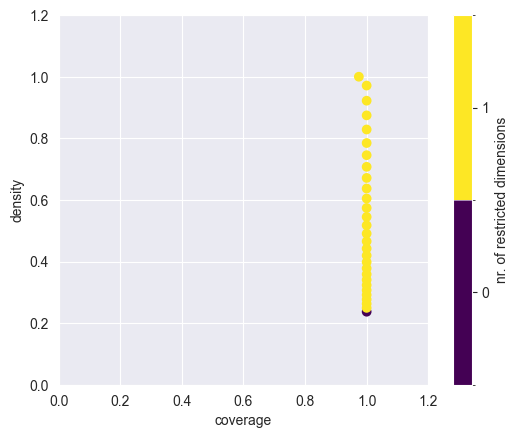

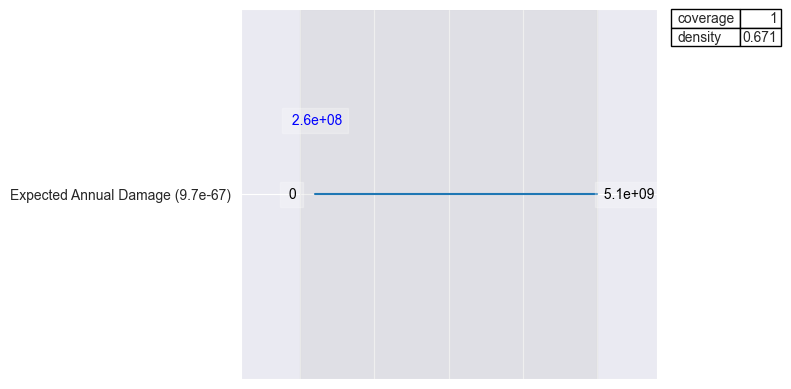

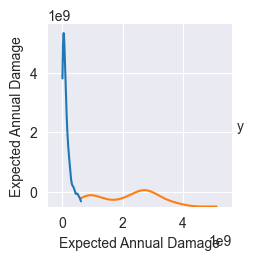

In [58]:
n= 20
box1.show_tradeoff()
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

PRIM for dike investment costs

In [42]:
experiments_df = pd.read_csv('experiments_bestpolicy.csv')
outcomes_df = pd.read_csv('outcomes_bestpolicy.csv')

data = pd.concat([experiments_df, outcomes_df], axis=1)
print(data.columns)

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0',
       'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0',
       'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0',
       'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0',
       'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0',
       'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 'scenario', 'policy',
       'model', 'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs'],
      dtype='object')


In [27]:
outcome_variable = 'Expected Annual Damage'

Type of Expected Annual Damage: float64


In [43]:
uncertainties= ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',]

In [45]:
prim_alg = prim.setup_prim(data,
                           classify = lambda y: y[ooi] > performance_threshold,
                        threshold= 0.75, 
                        incl_unc=uncertainties, 
                        mass_min=0.01
)

box1 = prim_alg.find_box()

ValueError: too many values to unpack (expected 2)

In [32]:
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05, paste_alpha=0.05, mass_min=0.05)
box = prim_alg.find_box()

AssertionError: 

In [ ]:
box.show_details()
box.show_tradeoff()

# Save the PRIM results for further analysis
prim_results = box.inspect(5)  # Example to inspect the top 5 boxes
prim_results.to_csv('prim_results.csv')

In [30]:
prim_alg = prim.Prim(data, data[outcome_variable], threshold=0.3, mode=prim.sdutil.RuleInductionType.REGRESSION)

AssertionError: 

In [26]:
box = prim_alg.find_box()

# Display box results
box.show_details()
box.show_tradeoff()

# Save the PRIM results for further analysis
prim_results = box.inspect(5)  
prim_results.to_csv('prim_results.csv')

[MainProcess/INFO] 1000 points remaining, containing 989 cases of interest


ValueError: p must be in range [0,1]

In [ ]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 100
n_policies = 10

with MultiprocessingEvaluator(dike_model, n_processes=1) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

print("Experiments completed:", results)



## Conclusion

In this notebook, we successfully analyzed the dike model using simulation and optimization techniques, and performed scenario discovery using PRIM. We configured the model, performed simulations, set up and executed optimizations, and analyzed the results to derive meaningful insights.


PRIM from experiments

In [9]:

import pandas as pd
from ema_workbench.analysis import prim
from ema_workbench import Scenario

# Load the experiments and outcomes
experiments = pd.read_csv('experiments_bestpolicy.csv')
outcomes = pd.read_csv('outcomes_bestpolicy.csv')

# Combine experiments and outcomes for PRIM analysis
data = pd.concat([experiments, outcomes], axis=1)

# outcomes of interest for PRIM
outcome_variable = 'Expected Annual Damage' 

In [10]:

# Initialize PRIM
prim_alg = prim.Prim(data, data[outcome_variable], threshold=0.8)

# Perform PRIM analysis
box = prim_alg.find_box()

# Save the PRIM box results
box.inspection_plot()
box.show_tradeoff()
box.inspect(0)
box.inspect(style='graph')

# Save PRIM results to a file
prim_results = box.data
prim_results.to_csv('prim_results.csv', index=False)

# Save PRIM box limits
box_limits = pd.DataFrame(box.box_lim)
box_limits.to_csv('prim_box_limits.csv', index=False)


AssertionError: 

In [ ]:
# Define the outcome variable for worst-case scenario discovery (e.g., 'Total Costs')
outcome_var = 'Total Costs'

# Select the policy of interest, e.g., the policy with the minimum 'Total Costs'
best_policy_idx = outcomes_df[outcome_var].idxmin()
best_policy = policy_df.loc[best_policy_idx]

# Extract the uncertainties and outcomes
outcomes = outcomes_df[outcome_var]
uncertainties = dike_model.uncertainties 

In [ ]:
# Apply PRIM for scenario discovery
prim_alg = prim.Prim(uncertainties, outcomes, threshold=0.8, peel_alpha=0.05)
box = prim_alg.find_box()

In [ ]:
# Display the results
box.show_tradeoff()
plt.show()

# Show the details of the discovered box (worst-case scenarios)
box.inspect(style='graph')
plt.show()

box.inspect(style='table')

# Save the results of the PRIM analysis
box.write_pareto(filename='prim_results.csv')

In [ ]:
import pandas as pd
import numpy as np
from ema_workbench import Policy, Scenario
from ema_workbench.analysis import prim

# For multiple runs --->
# outcomes_files = [f'db_optimization_outcomes_{i}.csv' for i in range(5)]
# policies_files = [f'db_optimization_policies_{i}.csv' for i in range(5)]
# 
# outcomes_list = [pd.read_csv(file) for file in outcomes_files]
# policies_list = [pd.read_csv(file) for file in policies_files]
# 
# # Combine the data from different runs
# outcomes_df = pd.concat(outcomes_list, ignore_index=True)
# policies_df = pd.concat(policies_list, ignore_index=True)

outcomes_df = pd.read_csv('optimization_outcomes_singlerun.csv')
policy_df = pd.read_csv('optimization_policies_singlerun.csv')


# Define the outcome variable for worst-case scenario discovery (e.g., 'Total Costs')
outcome_var = 'Expected Number of Deaths'

# Select the policy of interest, e.g., the policy with the minimum 'Total Costs'
best_policy_idx = outcomes_df[outcome_var].idxmin()
best_policy = policy_df.loc[best_policy_idx]

# Extract the uncertainties and outcomes
uncertainties = policy_df.drop(columns=[outcome_var])
outcomes = outcomes_df[outcome_var]

# Apply PRIM for scenario discovery
prim_alg = prim.Prim(uncertainties, outcomes, threshold=0.8, peel_alpha=0.05)
box = prim_alg.find_box()

# Display the results
box.show_tradeoff()
plt.show()

# Show the details of the discovered box (worst-case scenarios)
box.inspect(style='graph')
plt.show()

box.inspect(style='table')

# Save the results of the PRIM analysis
box.write_pareto(filename='prim_results.csv')
